<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelo-CNN-para-la-Clasificación-de-Imágenes" data-toc-modified-id="Modelo-CNN-para-la-Clasificación-de-Imágenes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelo CNN para la Clasificación de Imágenes</a></span><ul class="toc-item"><li><span><a href="#Importación-de-librerías" data-toc-modified-id="Importación-de-librerías-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importación de librerías</a></span></li><li><span><a href="#Configuración-GPU" data-toc-modified-id="Configuración-GPU-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Configuración GPU</a></span></li><li><span><a href="#Funciones" data-toc-modified-id="Funciones-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Funciones</a></span><ul class="toc-item"><li><span><a href="#Image-reading" data-toc-modified-id="Image-reading-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Image reading</a></span></li><li><span><a href="#Model-results" data-toc-modified-id="Model-results-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Model results</a></span></li><li><span><a href="#Show-correct-predictions" data-toc-modified-id="Show-correct-predictions-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Show correct predictions</a></span></li><li><span><a href="#Show-wrong-predictions" data-toc-modified-id="Show-wrong-predictions-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Show wrong predictions</a></span></li></ul></li><li><span><a href="#Creación-del-dataset" data-toc-modified-id="Creación-del-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Creación del dataset</a></span></li><li><span><a href="#Construcción-de-modelos-propios" data-toc-modified-id="Construcción-de-modelos-propios-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Construcción de modelos propios</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Transfer Learning</a></span></li><li><span><a href="#Concatenación-de-modelos" data-toc-modified-id="Concatenación-de-modelos-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Concatenación de modelos</a></span></li><li><span><a href="#Modelo-final-y-evaluación" data-toc-modified-id="Modelo-final-y-evaluación-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Modelo final y evaluación</a></span></li><li><span><a href="#Exportación-del-modelo-para-puesta-en-producción" data-toc-modified-id="Exportación-del-modelo-para-puesta-en-producción-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Exportación del modelo para puesta en producción</a></span></li></ul></li></ul></div>

# Modelo CNN para la Clasificación de Imágenes

En este apartado, elaboraremos un **modelo de Red Neuronal Convolucional de TensorFlow**.

##  Importación de librerías

In [1]:
import tensorflow as tf              # Librería de DeepLearning de Google
from tensorflow import keras         # Librería de Redes Neuronales que se ejecuta sobre TF
import matplotlib.pyplot as plt      # Creación de gráficos
import os                            # Paths y directorios
import pathlib                       # Paths y directorios
import pandas as pd                  # Tratamiento de DataFrames
import numpy as np                   # Funciones matemáticas, algebraicas y otras

## Configuración GPU

Dado que mi **GPU tiene compatibilidad con Tensorflow** (arquitectura CUDA), haremos uso de la misma en los siguientes apartados.

Para ello, necesitamos descargar los siguientes componentes:
*   Visual Studio Community 2019(C++)
*   Controladores de GPU NVIDIA®
*   Kit de herramientas CUDA®
*   SDK de cuDNN: librería NVIDIA CUDA® para redes neuronales profundas en GPU.

Comprobamos si Tensorflow detecta tanto mi CPU como mi GPU (NVIDIA Geforce GTX 1060 GB):

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8740463393410662175
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4851040256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9244663276245242128
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


## Funciones

Definimos a continuación una serie de funciones que nos serán útiles para estructurar el código:

### Image reading

Definimos una función para **leer imágenes** a partir de utilidades de keras:


In [3]:
from tensorflow import keras 
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

La probamos sobre una de las imágenes previamente descargadas:

In [4]:
directory = os.getcwd()
image_directory = os.path.join(directory + '\Images')
image = read_image(image_directory + '\Edible\Agaricus arvensis 1 fp.jpg')

In [5]:
image.shape

(512, 512, 3)

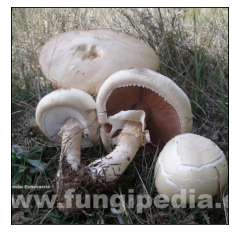

In [6]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

### Model results

Definimos una función para **graficar los resultados y evolución de las métricas de los modelos** que creemos:

In [7]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

### Show correct predictions

Definimos una función para ver algunas de las **imágenes en las que el modelo acierta la clasificación**:

In [8]:
def show_correct(val_ds, model, class_name_list, n_images=5):
    n_plots = 0
    for images, labels in val_ds:
        pred_probs = model.predict(images)
        preds = pred_probs.argmax(axis=-1)
        good_pred_inds = np.where(preds == labels)[0]
        for ind in list(good_pred_inds):
            n_plots += 1
            real_class = class_name_list[labels[ind].numpy()]
            pred_class = class_name_list[preds[ind]]
            prob = pred_probs[ind].max()
            prob_real = pred_probs[ind][[
                i for i, c in enumerate(class_name_list) if c == real_class
            ][0]]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title(
                'Predicted: {0}, prob: {1:.2f} \n real: {2}, prob: {3:.2f}'
                .format(pred_class, prob, real_class, prob_real))
            plt.show()

            if n_plots == n_images:
                return
    return                                                                                                  

### Show wrong predictions

Definimos ahora una función para ver algunas de las **imágenes en las que el modelo comete errores de clasificación**:

In [9]:
def show_errors(val_ds, model, class_name_list, n_images=5):
    n_plots = 0
    for images, labels in val_ds:
        pred_probs = model.predict(images)
        preds = pred_probs.argmax(axis=-1)
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_name_list[labels[ind].numpy()]
            pred_class = class_name_list[preds[ind]]
            prob = pred_probs[ind].max()
            prob_real = pred_probs[ind][[
                i for i, c in enumerate(class_name_list) if c == real_class
            ][0]]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title(
                'Predicted: {0}, prob: {1:.2f} \n real: {2}, prob: {3:.2f}'
                .format(pred_class, prob, real_class, prob_real))
            plt.show()

            if n_plots == n_images:
                return
    return

## Creación del dataset

Hacemos uso de la librería pathlib para crear un objeto data_dir de la clase Path sobre el que poder trabajar. Así, por ejemplo, podremos contar el total de imágenes .jpg que tenemos en todas las carpetas:

In [10]:
import pathlib
data_dir = pathlib.Path(image_directory)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total imágenes de setas: ", image_count)

Total imágenes de setas:  5561


In [11]:
Poisonous = list(data_dir.glob('Poisonous/*'))
Edible = list(data_dir.glob('Edible/*'))
Inedible = list(data_dir.glob('Inedible/*'))
print("\n Imágenes de setas comestibles: ", len(Edible), "\n Imágenes de setas no comestibles: ", len(Inedible), "\n", "Imágenes de setas venenosas: ", len(Poisonous))


 Imágenes de setas comestibles:  2456 
 Imágenes de setas no comestibles:  2217 
 Imágenes de setas venenosas:  888


Como vemos, hemos guardado 3 carpetas en nuestro directorio, correspondiente a las clases en las que vamos a clasificar las imágenes:


*   **Edible** *(Comestibles)*
*   **Inedible** *(No Comestibles)*
*   **Poisonous** *(Venenosas)*




Visualizamos un ejemplo aleatorio de cada una de las carpetas:

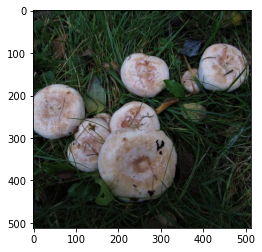

In [12]:
im = read_image(str(Poisonous[np.random.randint(0, len(Poisonous))]))
plt.imshow(im);

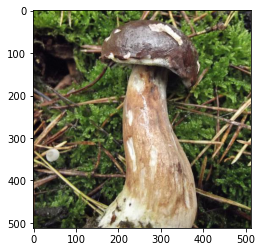

In [13]:
im = read_image(str(Edible[np.random.randint(0, len(Edible))]))
plt.imshow(im);

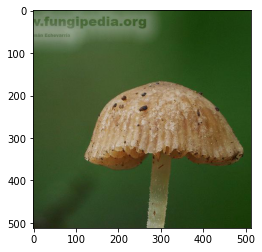

In [14]:
im = read_image(str(Inedible[np.random.randint(0, len(Inedible))]))
plt.imshow(im);

Ahora creamos un **dataset de TensorFlow** con las imágenes anteriormente obtenidas, a través del método[`image_dataset_from_directory ()`](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function):

In [15]:
image_size = (128,128)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # 80%  train, 20% validation
  subset='training',  # 'training' o 'validation', only  with 'validation_split'
  seed=1,
  image_size=image_size,  # Dimension (img_height, img_width) for rescaling
  batch_size=64
)

Found 5561 files belonging to 3 classes.
Using 4449 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=1,
  image_size=image_size,
  batch_size=64)

Found 5561 files belonging to 3 classes.
Using 1112 files for validation.


Comprobamos las **distintas clases** que tiene el dataset:

In [17]:
class_name_list = train_ds.class_names
class_name_list

['Edible', 'Inedible', 'Poisonous']

**Nos aseguramos de cachear las imágenes en la memoria RAM** para no tener que cargarlas constantemente y ganar así velocidad:

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_c = train_ds.cache().shuffle(1500).prefetch(buffer_size=AUTOTUNE)
val_ds_c = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Visualizamos ahora un batch de imágenes** barajadas de ejemplo del training set:

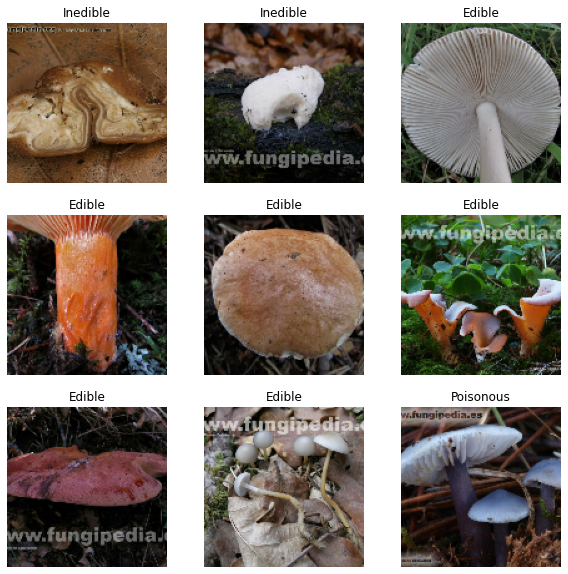

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name_list[labels[i]])
        plt.axis("off")

## Construcción de modelos propios

**Construimos el modelo.** El input tendrá una **dimensión de (n, n, 3)**, correspondiente a la altura, anchura y nº de canales de color.

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 128, 128, 3)
(64,)


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

En todo lo sucesivo utilizaremos la [API Funcional de Keras](https://keras.io/guides/functional_api/) para declarar y construir las sucesivas capas del modelo.

Creamos la primera **Red Neuronal Convolucional (CNN)**, una muy sencilla con dos convoluciones: 

In [22]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)    # Incluimos un preprocesamiento para reescalar las imágenes normalizando los valores de los píxeles a un rango entre 0 y 1.

# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='valid', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='valid', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Flattening
flat = layers.Flatten(name='flatten')(pool_2)

# Fully-connected
dense = layers.Dense(16, activation='relu', name='dense')(flat)

# Classification
outputs = layers.Dense(3, activation='softmax', name='output')(dense)

model_1 = keras.Model(inputs=inputs, outputs=outputs)

**Compilamos el modelo:**

In [23]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Lo entrenamos:**

In [24]:
epochs = 20
history_1 = model_1.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=epochs,
    verbose=0,
)

**Visualizamos los resultados** y la evolución del *accuracy* y la función de pérdida:

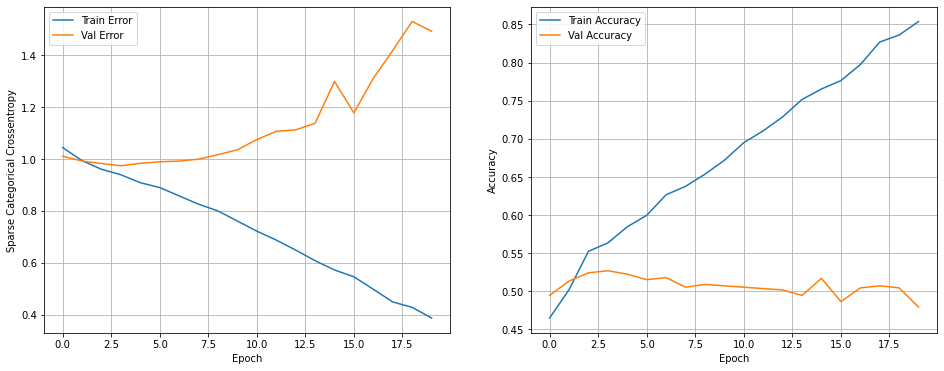

In [25]:
show_loss_accuracy_evolution(history_1)

Probamos ahora  utilizando **Data Augmentation** para transformar aleatoriamente las imágenes y aumentar artificialmente nuestro dataset:

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomCrop(100,100),
  ]
)

Vemos qué sucede cuando aplicamos estas técnicas de **Data Augmentation** con tres imágenes aleatorias:

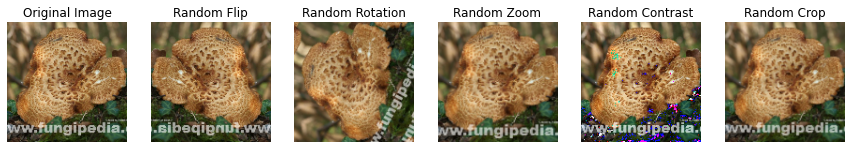

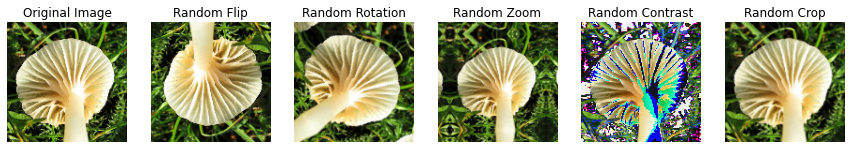

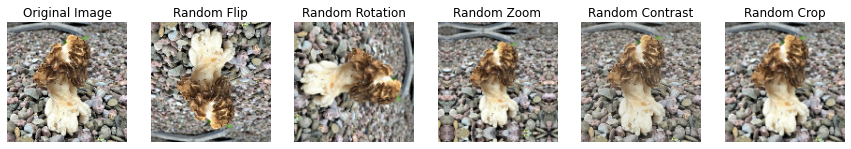

In [27]:
for images, _ in train_ds.take(3):
    plt.figure(figsize=(15, 6))

    img = images[0:1]
    ax = plt.subplot(1, 6, 1)
    plt.imshow(img[0].numpy().astype("uint8"))
    plt.title('Original Image')
    plt.axis("off")

    ax = plt.subplot(1, 6, 2)
    img_aug = layers.experimental.preprocessing.RandomFlip(
        "horizontal_and_vertical")(img)
    plt.imshow(img_aug[0].numpy().astype("uint8"))
    plt.title('Random Flip')
    plt.axis("off")

    ax = plt.subplot(1, 6, 3)
    img_aug = layers.experimental.preprocessing.RandomRotation(0.25)(img)
    plt.imshow(img_aug[0].numpy().astype("uint8"))
    plt.title('Random Rotation')
    plt.axis("off")

    ax = plt.subplot(1, 6, 4)
    img_aug = layers.experimental.preprocessing.RandomZoom(0.25)(img)
    plt.imshow(img_aug[0].numpy().astype("uint8"))
    plt.title('Random Zoom')
    plt.axis("off")

    ax = plt.subplot(1, 6, 5)
    img_aug = tf.keras.layers.experimental.preprocessing.RandomContrast(0.25)(img)
    plt.imshow(img_aug[0].numpy().astype("uint8"))
    plt.title('Random Contrast')
    plt.axis("off")
    
    ax = plt.subplot(1, 6, 6)
    img_aug = tf.keras.layers.experimental.preprocessing.RandomCrop(150, 150)(img)
    plt.imshow(img_aug[0].numpy().astype("uint8"))
    plt.title('Random Crop')
    plt.axis("off")

In [28]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
data_aug = data_augmentation(inputs)
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(data_aug)

# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='valid', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='valid', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Flattening
flat = layers.Flatten(name='flatten')(pool_2)

# Fully-connected
dense = layers.Dense(64, activation='relu', name='dense')(flat)

# Classification
outputs = layers.Dense(3, activation='softmax', name='output')(dense)

model_2 = keras.Model(inputs=inputs, outputs=outputs)

In [29]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [30]:
epochs = 20
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0,
)

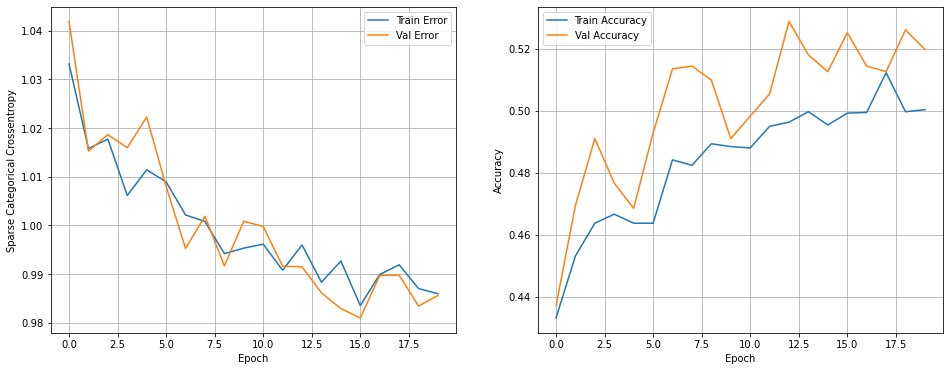

In [31]:
show_loss_accuracy_evolution(history_2)

Probamos ahora **variando ligeramente los parámetros**, añadiendo convoluciones, etc:

In [32]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
data_aug = data_augmentation(inputs)
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(data_aug)
    
# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='same', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='same', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_2')(conv_2)

# Conv Layer 3
conv_3 = layers.Conv2D(16, 3, padding='same', activation='relu', name='conv_3')(pool_2)
pool_3 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_3')(conv_3)

# Conv Layer 4
conv_4 = layers.Conv2D(32, 3, padding='same', activation='relu', name='conv_4')(pool_3)
pool_4 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_4')(conv_4)

# Flattening
flat = layers.Flatten(name='flatten')(pool_4)

# Fully-connected
dense = layers.Dense(64, activation='relu', name='dense')(flat)

# Classification
outputs = layers.Dense(3, activation='softmax', name='output')(dense)

model_3 = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [34]:
epochs = 50
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 0,
)

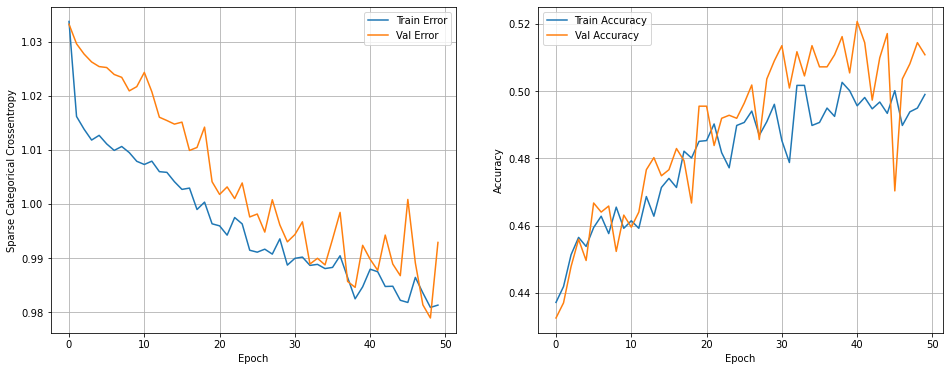

In [35]:
show_loss_accuracy_evolution(history_3)

Añadiremos ahora algunas **técnicas de regularización del *overfitting*** como *DropOut*, *EarlyStopping* o modificación del *Batch Size*, e iteraremos hasta intentar alcanzar el punto de convergencia de la *accuracy* (con *Early Stopping*):

In [36]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # if during 10 epochs there is no improvement in `val_loss`, the execution will stop
    verbose=1)

In [37]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
data_aug = data_augmentation(inputs)
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(data_aug)
    
# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='same', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='same', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_2')(conv_2)

# Conv Layer 3
conv_3 = layers.Conv2D(16, 3, padding='same', activation='relu', name='conv_3')(pool_2)
pool_3 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_3')(conv_3)
pool_3 = layers.Dropout(0.25)(pool_3)

# Conv Layer 4
conv_4 = layers.Conv2D(32, 3, padding='same', activation='relu', name='conv_4')(pool_3)
pool_4 = layers.AveragePooling2D(pool_size=(3, 3), name='pool_4')(conv_4)
pool_4 = layers.Dropout(0.25)(pool_4)

# Flattening
flat = layers.Flatten(name='flatten')(pool_4)

# Fully-connected
dense = layers.Dense(64, activation='relu', name='dense')(flat)
dense = layers.Dropout(0.25)(dense)

# Classification
outputs = layers.Dense(3, activation='softmax', name='output')(dense)

model_4 = keras.Model(inputs=inputs, outputs=outputs)

In [38]:
model_4.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [39]:
epochs = 50
batch_size = 128,
history_4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es_callback],
    verbose = 0,
)

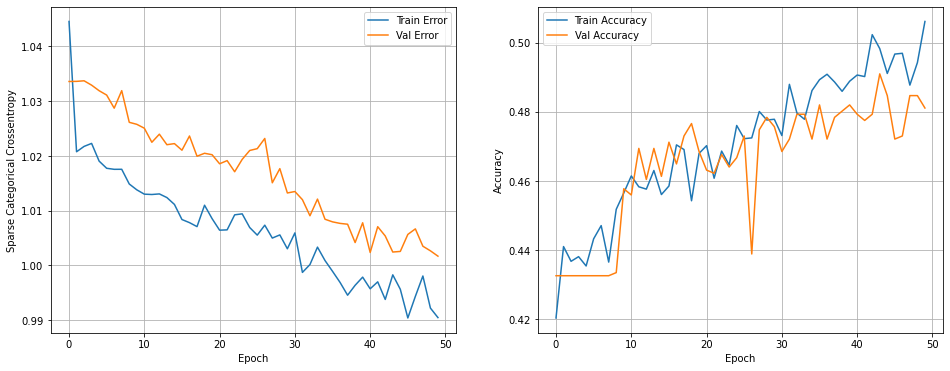

In [40]:
show_loss_accuracy_evolution(history_4)

Parece que **los modelos más sencillos funcionan mejor** (una convolución con dos filtros y otra con cuatro). Veamos hasta qué *accuracy* llegamos incluyendo un *Early Stopping* poco restrictivo (paciencia de 20) y un *Batch Size* grande:

In [41]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20, 
    verbose=1)

inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
data_aug = data_augmentation(inputs)
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(data_aug)

# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='same', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='valid', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Flattening
flat = layers.Flatten(name='flatten')(pool_1)

# Fully-connected
dense = layers.Dense(16, activation='relu', name='dense')(flat)

# Classification
outputs = layers.Dense(3, activation='softmax', name='output')(dense)

model_5 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [42]:
model_5.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [43]:
epochs = 200
batch_size = 256,
history_5 = model_5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es_callback],
    verbose = 0,
)

Epoch 00127: early stopping


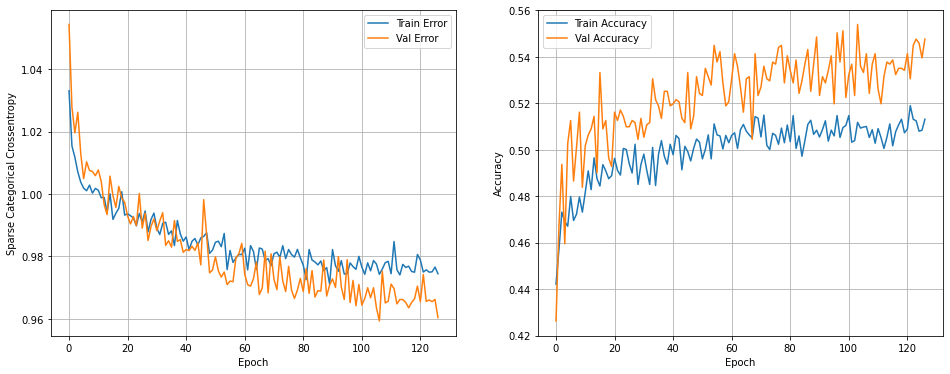

In [44]:
show_loss_accuracy_evolution(history_5)

Como vemos, alcanzaríamos una **precisión ~55%** con nuestro mejor modelo.

## Transfer Learning

Una parte esencial de las redes convolucionales, y del Deep Learning en general, es el ***Transfer Learning***. Muchísimos equipos de investigación se dedican a resolver distintos problemas a través de diversos modelos, tras lo que los hacen públicos y accesibles.


En [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) están disponibles varios de estos modelos preentrenados, que pueden compararse [aquí](https://keras.io/api/applications/#available-models). 

**Comparemos los resultados de 5 de los modelos más ligeros disponibles** con nuestro dataset:

[Xception](https://keras.io/api/applications/xception/)

In [45]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.Xception(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.xception.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)
# Flattening
flat = layers.Flatten()(x)
# Fully-connected
dense = layers.Dense(128, activation='relu')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)
# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_tl = tf.keras.Model(inputs, outputs)
# Compile
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Fit
history1 = model_tl.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=10,
    batch_size=128,
    verbose = 0,
)
results1 = model_tl.evaluate(val_ds, verbose = 0)

[ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function)

In [46]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.ResNet50V2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)
# Flattening
flat = layers.Flatten()(x)
# Fully-connected
dense = layers.Dense(128, activation='relu')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)
# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_tl = tf.keras.Model(inputs, outputs)
# Compile
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Fit
history2 = model_tl.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=10,
    batch_size=128,
    verbose = 0,
)
results2 = model_tl.evaluate(val_ds, verbose = 0)

[InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2/)

In [47]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)
# Flattening
flat = layers.Flatten()(x)
# Fully-connected
dense = layers.Dense(128, activation='relu')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)
# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_tl = tf.keras.Model(inputs, outputs)
# Compile
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Fit
history3 = model_tl.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=10,
    batch_size=128,
    verbose = 0,
)
results3 = model_tl.evaluate(val_ds, verbose = 0)

[MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)

In [48]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)
# Flattening
flat = layers.Flatten()(x)
# Fully-connected
dense = layers.Dense(128, activation='relu')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)
# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_tl = tf.keras.Model(inputs, outputs)
# Compile
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Fit
history4 = model_tl.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=10,
    batch_size=128,
    verbose = 0,
)
results4 = model_tl.evaluate(val_ds, verbose = 0)

[DenseNet201](https://keras.io/api/applications/densenet/#densenet201-function)

In [49]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.DenseNet201(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.densenet.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)
# Flattening
flat = layers.Flatten()(x)
# Fully-connected
dense = layers.Dense(128, activation='relu')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)
# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_tl = tf.keras.Model(inputs, outputs)
# Compile
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
# Fit
history5 = model_tl.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=10,
    batch_size=128,
    verbose = 0,
)
results5 = model_tl.evaluate(val_ds, verbose = 0)

Vemos cual ha sido, en esta aproximación, los resultados obtenidos:

In [50]:
print(results1[1])
print(results2[1])
print(results3[1])
print(results4[1])
print(results5[1])

0.5611510872840881
0.5791366696357727
0.5449640154838562
0.5872302055358887
0.5728417038917542


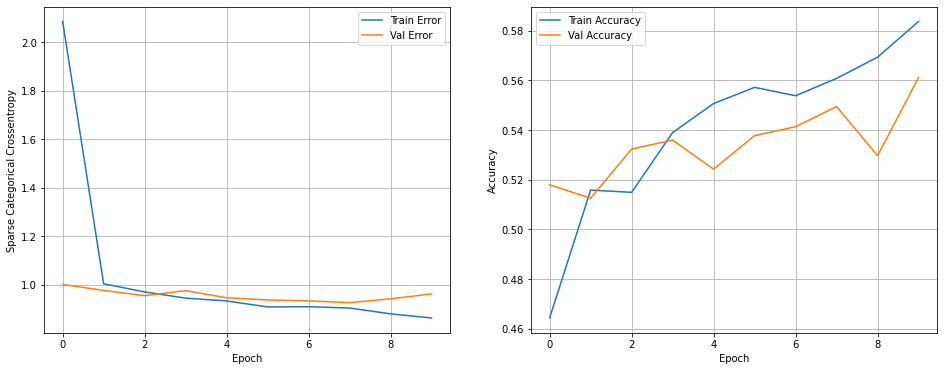

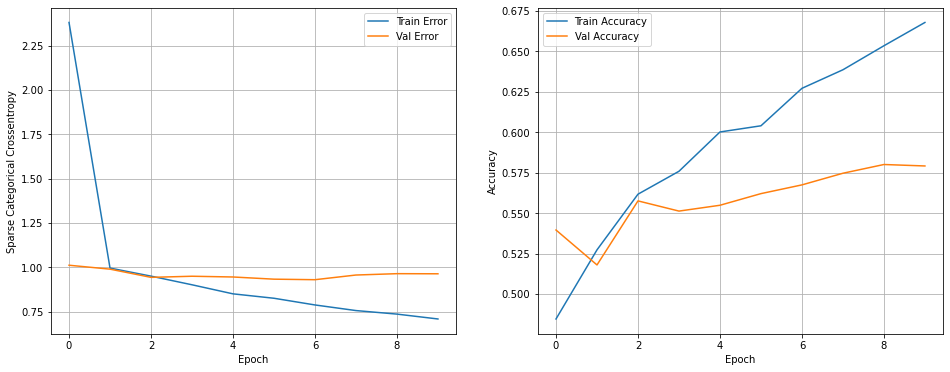

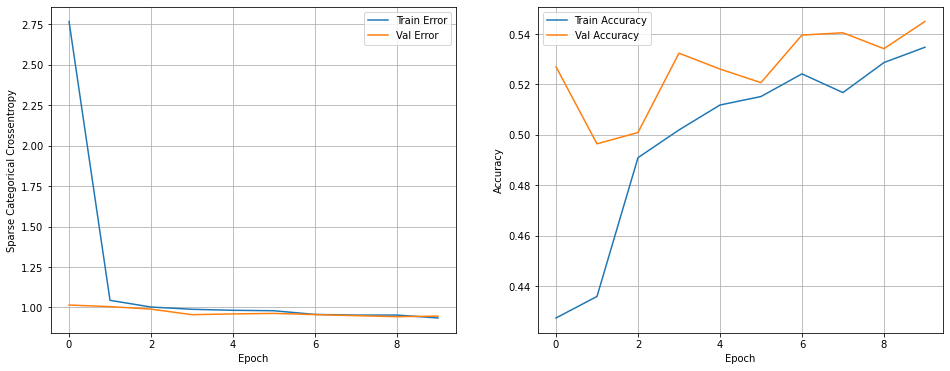

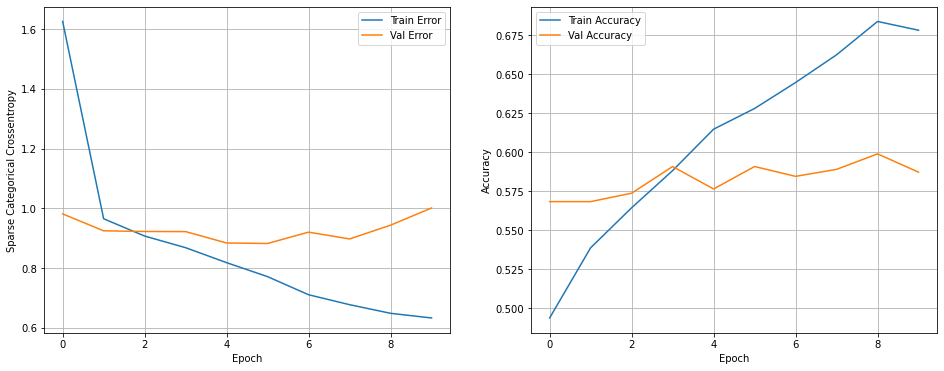

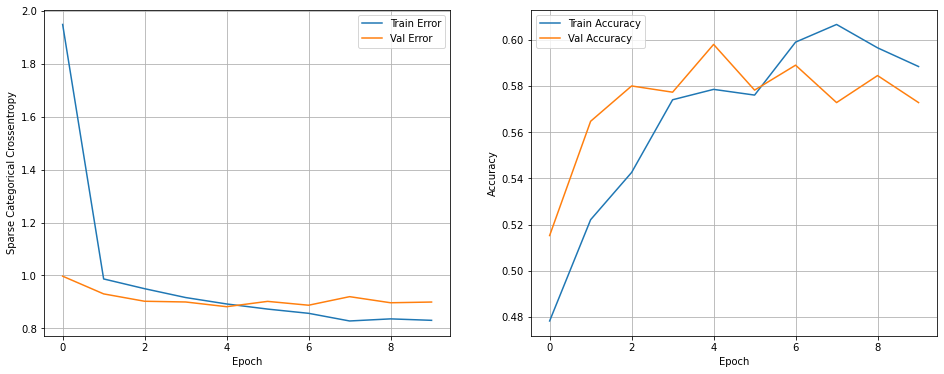

In [51]:
show_loss_accuracy_evolution(history1)
show_loss_accuracy_evolution(history2)
show_loss_accuracy_evolution(history3)
show_loss_accuracy_evolution(history4)
show_loss_accuracy_evolution(history5)

Como podemos observar, el que **mejores resultados nos ha ofrecido** en esta pequeña comparativa, ha sido el [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function). Vemos hasta donde podemos llegar con él incluyendo *Early Stopping* a la función de pérdida:

Epoch 00013: early stopping


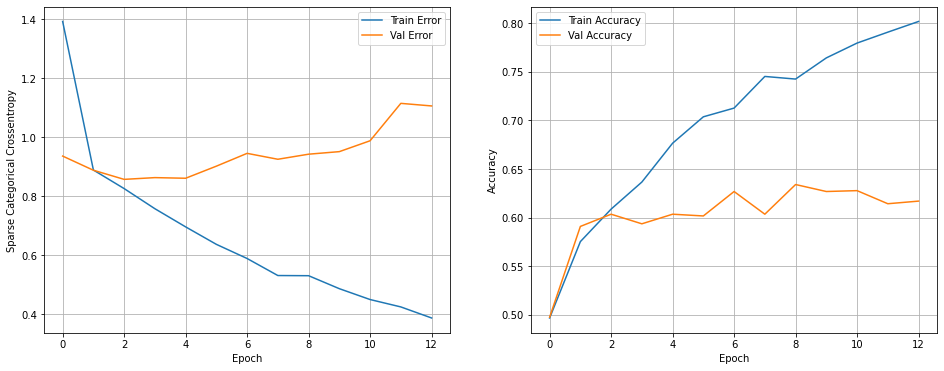

In [52]:
# Load model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')

# Callbacks
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, 
    verbose=1)

# Pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# Flattening
flat = layers.Flatten()(x)

# Fully-connected
dense = layers.Dense(128, activation='relu', name='fully-connected')(flat)
dense = tf.keras.layers.Dropout(0.5)(dense)

# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_mobilenet = tf.keras.Model(inputs, outputs)

# Compile
model_mobilenet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Fit
history_mobilenet = model_mobilenet.fit(
    train_ds_c,
    validation_data=val_ds_c,
    epochs=50,
    batch_size=128,
    verbose = 0,
    callbacks = [es_callback],
)
results_mobilenet = model_mobilenet.evaluate(val_ds, verbose = 0)
show_loss_accuracy_evolution(history_mobilenet)

Como vemos, utilizando [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) con nuestro dataset, **se produce un *overfitting*** bastante acusado.

## Concatenación de modelos

Procedemos ahora a **concatenar el modelo previamente creado con el [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)**, para ver si logramos mejorar las métricas. 


In [53]:
# Callbacks
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1)

# Kernel regularizers
from tensorflow.keras import regularizers
kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=5e-4)

# Load pre-trained model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

# Inputs and rescaling
inputs = tf.keras.Input(shape=image_size+(3, ), name='input')
reescaling = preprocess_input(inputs)
data_aug = data_augmentation(reescaling)

# Conv Layer 1
conv_1 = layers.Conv2D(4, 3, padding='valid', kernel_regularizer = kernel_regularizer, activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
pool_1 = layers.GaussianNoise(stddev=0.2)(pool_1)
pool_1 = layers.Dropout(0.25)(pool_1)
pool_1 = layers.BatchNormalization()(pool_1)


# Conv Layer 2
conv_2 = layers.Conv2D(8, 3, padding='valid', kernel_regularizer = kernel_regularizer, activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)
pool_1 = layers.GaussianNoise(stddev=0.2)(pool_1)
pool_2 = layers.Dropout(0.25)(pool_2)
pool_2 = layers.BatchNormalization()(pool_2)


# Flattening
x1 = layers.Flatten(name='flatten')(pool_2)

# Pretrained model
x2 = pretrained_model(reescaling, training=False)
x2 = tf.keras.layers.Flatten()(x2)

# Concatenate
x = tf.keras.layers.Concatenate()([x1, x2])
x = layers.GaussianNoise(stddev=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)

# Fully-connected
x = layers.Dense(128, kernel_regularizer = kernel_regularizer, activation='relu', name='dense')(x)
x = layers.GaussianNoise(stddev=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)

# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model_6= keras.Model(inputs, outputs)



In [54]:
model_6.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_6 = model_6.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=16,
    callbacks= [es_callback],
    verbose = 0,
)

Epoch 00010: early stopping


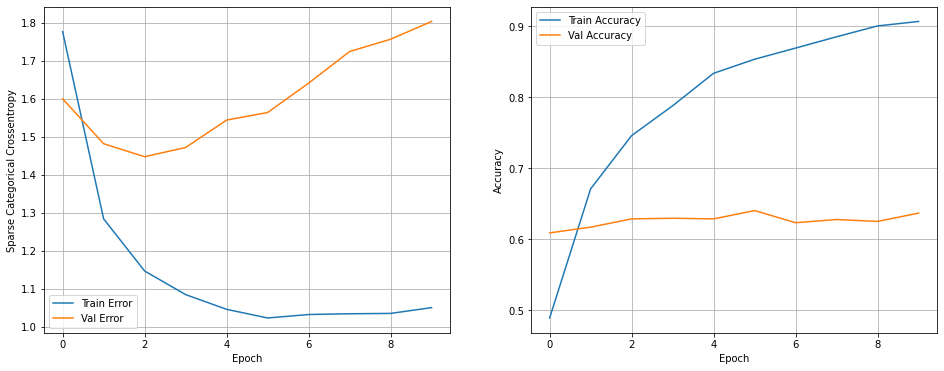

In [55]:
show_loss_accuracy_evolution(history_6)

Como vemos, **no somos capaces de eliminar el *overfitting* que presenta el modelo concatenado**. Además, tanto en el *train* como en el *validation* set, la función de pérdida está en unos valores muy elevados y crecientes con las épocas.

## Modelo final y evaluación

A continuación, se presenta el **modelo final elegido**. Aumentamos el tamaño de las imágenes del dataset para ajustar al máximo la *accuracy*:

In [105]:
image_size = (224,224)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.2, 
      subset='training', 
      seed=1,
      image_size=image_size,
      batch_size=128
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset='validation',
      seed=1,
      image_size=image_size,
      batch_size=128
)

Found 5561 files belonging to 3 classes.
Using 4449 files for training.
Found 5561 files belonging to 3 classes.
Using 1112 files for validation.


In [106]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_c = train_ds.cache().shuffle(1500).prefetch(buffer_size=AUTOTUNE)
val_ds_c = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [107]:
# Callbacks
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Fijamos la paciencia a 4, pues la validation_loss está subiendo muy rápidamente
    verbose=1)

# Load pre-trained model, freeze weights and preprocess inputs
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

# Inputs and rescaling
inputs = tf.keras.Input(shape=image_size+(3, ), name='input')
reescaling = preprocess_input(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(2, 3, padding='valid', activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
pool_1 = layers.Dropout(0.25)(pool_1)
pool_1 = layers.BatchNormalization()(pool_1)

# Conv Layer 2
conv_2 = layers.Conv2D(4, 3, padding='valid', activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)
pool_2 = layers.Dropout(0.25)(pool_2)
pool_2 = layers.BatchNormalization()(pool_2)

# Flattening
x1 = layers.Flatten()(pool_2)

# Pretrained model
x2 = pretrained_model(reescaling, training=False)
x2 = layers.Flatten()(x2)

# Concatenate
x = layers.Concatenate()([x1, x2])
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)

# Fully-connected
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)

# Classification
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model= keras.Model(inputs, outputs, name = 'Mushroom_Edibility_Classifier')

Epoch 00009: early stopping


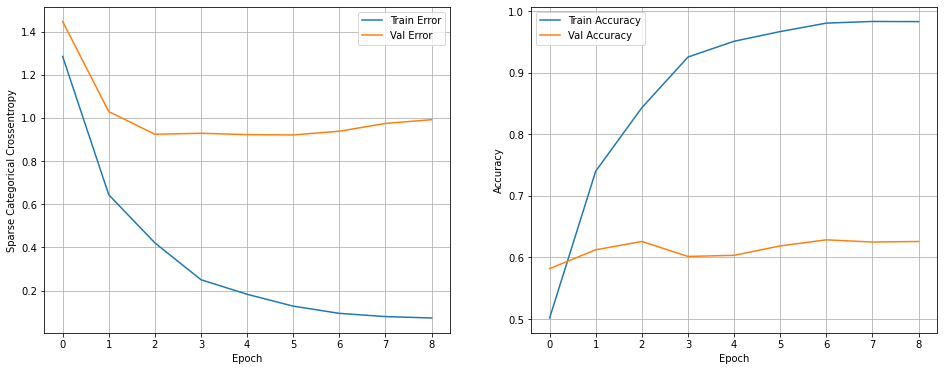

In [108]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=128,
    callbacks= [es_callback],
    verbose = 0,
)
show_loss_accuracy_evolution(history)

In [109]:
results = model.evaluate(val_ds, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.9916329383850098
Test Accuracy: 0.6258992552757263


Observamos ahora **en qué tipo de imágenes acierta y comete errores nuestro modelo**:

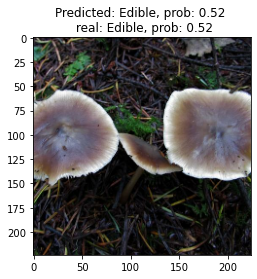

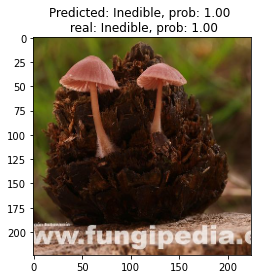

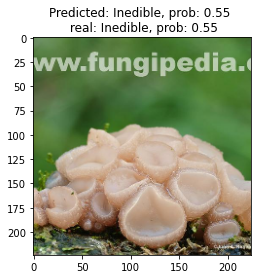

In [110]:
show_correct(val_ds, model, class_name_list, n_images=3)

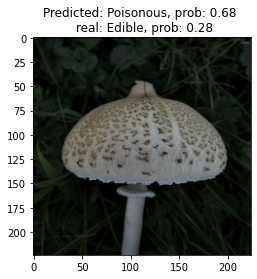

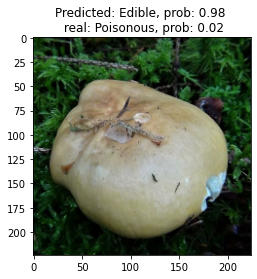

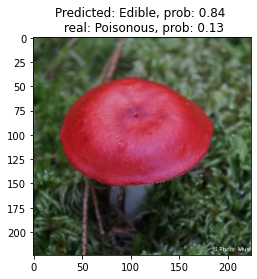

In [111]:
show_errors(val_ds, model, class_name_list, n_images=3)

Obtenemos la **Matriz de Confusión** de nuestro modelo, obtenida a través de [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [112]:
import sklearn.metrics as metrics
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    labels = np.concatenate([labels, y.numpy()])
cm = metrics.confusion_matrix(y_true=labels, y_pred=predictions)

Y la graficamos, gracias a [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions):

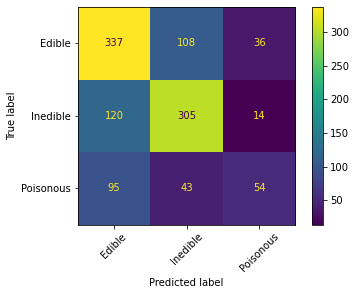

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=labels, y_pred=predictions)
tick_marks = np.arange(len(class_name_list))
plt.xticks(tick_marks, class_name_list, rotation=45)
plt.yticks(tick_marks, class_name_list)
plt.show()

**Métricas de nuestro modelo**

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_true=labels, y_pred=predictions, target_names=class_name_list, digits = 2))

              precision    recall  f1-score   support

      Edible       0.61      0.70      0.65       481
    Inedible       0.67      0.69      0.68       439
   Poisonous       0.52      0.28      0.36       192

    accuracy                           0.63      1112
   macro avg       0.60      0.56      0.57      1112
weighted avg       0.62      0.63      0.61      1112



## Exportación del modelo para puesta en producción

**Guardamos el modelo final para su uso posterior en la Web App:**

In [115]:
model.save('model.h5')

C:\Users\Usuario\anaconda3\envs\python38gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
